In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '8'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train_bbnet import get_args, load_model, IsMovingTarget
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = aff_node.shape[-1] // 2
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects

import time 

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False):
    dataset.is_test = False
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = torch.sigmoid(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  


/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

# Train a BBNet in rounds

In [4]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(4)],
    split='training',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load the motion model for round 0

In [6]:
# motion_path = '../checkpoints/35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth'
motion_path = '../checkpoints/motion-rnd0-tdw-bs8-large-fullplay-tr0-8.pth'
mclass_net = load_model(
                       motion_path,
                       small=False, 
                       cuda=True, 
                       train=False)
mclass_net.module.freeze_bn()
mclass_net.eval()
print(layer_utils.num_parameters(mclass_net))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier
5555009


In [7]:
# ex = 0
# viz_raft_prediction(mclass_net, tdw_dataset, ex=ex, iters=[1,6,12,24], thingness=True, thresh=None)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load a BBNet

In [7]:
ckpts = !ls ../checkpoints/*bbnet_rnd*
models = sorted(set(['_'.join(s.split('_')[1:]) for s in ckpts]))
models

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['bbnet_rnd0motion_fullplayFr5_bs8.pth',
 'bbnet_rnd0static_fullplayFr5_bs4.pth',
 'bbnet_rnd0static_fullplayFr5_bs8.pth',
 'bbnet_rnd1static_fullplayFr5_bs1.pth']

In [59]:
import os.path as osp
# load_path = '../checkpoints/30000_bbnet_rnd0static_fullplayFr5_bs8.pth'

load_step = 5000
load_path = osp.join('../checkpoints', '_'.join([str(load_step), models[0]]))

bbnet = load_model(
            load_path=load_path,
#             static_load_path=load_path,
            model_class='bbnet',
            affinity_radius=5,
            cuda=True, 
            train=True)

# bbnet.motion_model = bbnet_classifier
print("num parameters", layer_utils.num_parameters(bbnet))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model in train_static mode
<All keys matched successfully> BBNet
num parameters 7761380


In [50]:
def get_data(dataset, ex, up_to=2):
    return [x[None] for x in dataset[ex][:up_to]]

def train_step(data, model, optimizer, **kwargs):
    optimizer.zero_grad()
    preds = model(*[x.cuda() for x in data], **kwargs)
#     loss = sum(model.loss_list)
    loss = preds[-1]
    loss.backward()
    optimizer.step()
    target = getattr(model, 'target', None)
    return (data, preds, target, loss)

def eval_step(data, model, teacher=None, mode='val', out_idx=-1, upsample=False, **kwargs):
    model.module.mode = mode
    if teacher is not None:
        if not upsample:
            teacher_motion = teacher(*[x.cuda() for x in data], **kwargs)[out_idx].detach()
            data.append(teacher_motion)
        else:
            mask, teacher_motion = [out.detach() for out in teacher(*[x.cuda() for x in data], **kwargs)]
            data.extend([teacher_motion, mask])
    preds = model(*[x.cuda() for x in data], **kwargs)
    return (data, preds)

def train_with_teacher(dataloader, model, teacher, mode='train_static',
                       lr=0.0003, num_steps=100, print_every=5, plot_every=100, out_idx=-1,
                       teacher_iters=1, weight_decay=0.0001,
                       load_path=None, save_path=None,
                       **kwargs):
    
    if load_path is not None:
        did_load = model.load_state_dict(torch.load(load_path), strict=False)
        print("loaded %s, %s" % (load_path, did_load))
        
    model.train()
    model.module.mode = mode
    if mode == 'train_static':
        optimizer = torch.optim.AdamW(model.static_model.parameters(), 
                                      lr=lr, weight_decay=weight_decay, eps=1e-8)
    elif mode == 'train_motion':
        optimizer = torch.optim.AdamW(model.motion_model.parameters(), 
                                      lr=lr, weight_decay=weight_decay, eps=1e-8)
    loss_curve = []
    step, epoch, running_loss = 0, 0, 0.0
    while (step <= num_steps):
        epoch += 1
        for _step, data in enumerate(dataloader):
            data = data[:2]
            teacher_motion = eval_step(data, teacher, test_mode=True, iters=teacher_iters)[-1][out_idx].detach()
            data.append(teacher_motion)
            loss = train_step(data, model, optimizer, **kwargs)[-1]
            loss_curve.append(loss.item())
            running_loss += (loss.item()) / print_every
        
            if (step % print_every) == 0:
                print("%s w teacher epoch %d / step %d ---- loss %.3f" % (model.mode, epoch-1, _step, running_loss))
                running_loss = 0.0
                
            if (step % plot_every) == 0:
                plt.plot(loss_curve)
                plt.show()
                
            step += 1            
            if step >= num_steps:
                break
            
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        print("saved model weights to %s" % save_path)
        
    return loss_curve

def train_selfsup(dataloader, model, mode='train_motion',
                  num_steps=100, print_every=5, plot_every=100, lr=0.0003, weight_decay=0.0001,
                  load_path=None, save_path=None,
                  **kwargs):
    
    if load_path is not None:
        did_load = model.load_state_dict(torch.load(load_path), strict=False)
        print("loaded %s, %s" % (load_path, did_load))    
    
    model.train()
    assert mode in ['train_static', 'train_motion', 'train_both'], mode
    model.module.mode = mode
    if mode == 'train_motion':
        params = model.motion_model.parameters()
    elif mode == 'train_static':
        params = model.static_model.parameters()
    elif mode == 'train_both':
        params = model.parameters()
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay, eps=1e-8)
    loss_curve = []
    step, epoch, running_loss = 0, 0, 0.0
    while (step <= num_steps):
        epoch += 1
        for _step, data in enumerate(dataloader):
            data = data[:2]
            loss = train_step(data, model, optimizer, **kwargs)[-1]
            loss_curve.append(loss.item())
            running_loss += (loss.item()) / print_every
        
            if (step % print_every) == 0:
                print("%s epoch %d / step %d ---- loss %.3f" % (model.mode, epoch-1, _step, running_loss))
                running_loss = 0.0
                
            if (step % plot_every) == 0:
                plt.plot(loss_curve)
                plt.show()                
                
            step += 1
            if step >= num_steps:
                break
            
    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        print("saved model weights to %s" % save_path)
            
    return loss_curve    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
prop = fprop.MotionPropagator(
    num_samples=4, 
    confidence_thresh=2,
    num_initial_points=None,
    motion_thresh=0.25,
    radius=1, 
    num_iters=50, 
    update_thresh=0.1).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
ex = 100
bbnet.module.upsample_motion_target = False
data, preds = eval_step(get_data(tdw_dataset, ex), bbnet, teacher=None, 
                        iters=6, test_mode=True, upsample=False,
                        mode='train_both')
preds = list(preds)
# h, fire = prop(preds[0], preds[1])
# preds.insert(2, h)
preds.insert(2, torch.ones_like(preds[0]))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model in train_both mode


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


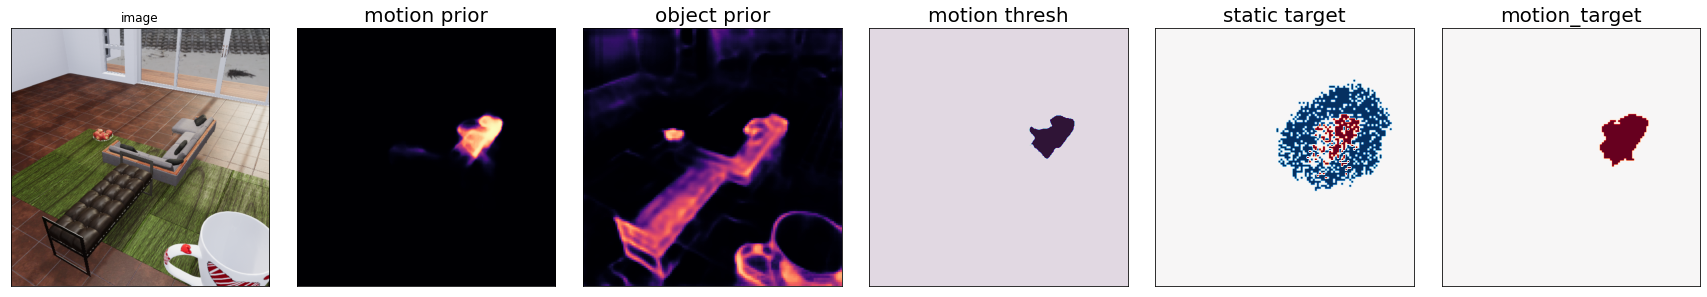

In [53]:
a_ind = 60
fig, axes = plt.subplots(1,6,figsize=(24,4))
vis_utils.imshow(data[0]/255., axes[0])
thresh = 0.5
titles = ['motion prior', 'object prior', 'motion thresh', 'static target', 'motion_target']
axes[0].set_title('image')
axes[0].set_xticks([])
axes[0].set_yticks([])
for i in range(1,6):
    plot = preds[i-1]
    if plot is None:
        plot = torch.ones_like(data[0])
        
    if i == 2:
        plot = plot[:,a_ind,None]
        
    if i in [1,2]:
        plot = torch.sigmoid(plot)
        vis_utils.imshow(plot, axes[i], cmap='magma', vmin=0, vmax=1)
    
    elif i in [3]:
        plot = (torch.sigmoid(preds[0]) > thresh).float()
#         plot = preds[i]
        vis_utils.imshow(plot, axes[i], cmap='twilight', vmin=0, vmax=2)
    
    if i in [4,5]:
        vis_utils.imshow(plot, axes[i], cmap='RdBu_r', vmin=-1, vmax=1)
    axes[i].set_title(titles[i-1], fontsize=20)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

## Can original upsampling mask be reused?

In [26]:
preds[0].shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 1, 512, 512])

In [14]:
data, teacher_preds =  eval_step(get_data(tdw_dataset, ex), mclass_net, iters=24, test_mode=True)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


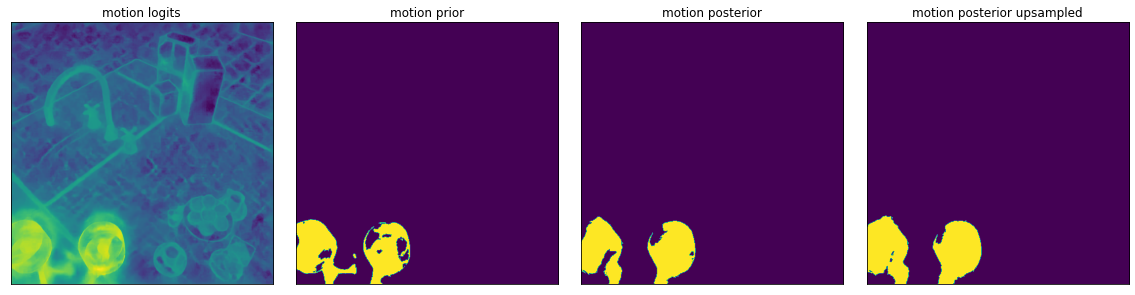

In [15]:
mask, motion = teacher_preds
mtarget = transforms.Resize([64,64])(preds[-2].float())
ups_mtarget = mclass_net.module.upsample_flow(mtarget, mask)

fig, axes = plt.subplots(1,4,figsize=(16,4))
vis_utils.imshow(motion, axes[0])
vis_utils.imshow(torch.sigmoid(motion) > 0.1, axes[1])
vis_utils.imshow(preds[-2] > 0.5, axes[2])
vis_utils.imshow(ups_mtarget > 0.999, axes[3])

titles = ['motion logits', 'motion prior', 'motion posterior', 'motion posterior upsampled']
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i])
    
plt.tight_layout()
plt.show()


## Evaluate BBNet -- does it improve on the original motion?

In [43]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                  thingness=False,
                  pred_idx=0,
                  sigmoid=True,
                  teacher=None,
                  upsample=False
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
        
    blob = dataset[ex]
    try:
        img1, img2, flow = blob[:3]
    except:
        img1, img2 = blob[:2]
        flow = torch.zeros_like(img1[:2])
    if teacher is not None:
        ups_mask, teacher_motion = teacher(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
        pred = model(img1[None].cuda(), img2[None].cuda(), teacher_motion, iters=iters, test_mode=True)[pred_idx]
    else:
        pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)[pred_idx]
    
    if upsample and (teacher is not None):
        U = int(np.sqrt(ups_mask.shape[1] // 9))
        size = list(teacher_motion.shape[-2:])
        size_ds = [size[0] // U, size[1] // U]
        pred = transforms.Resize(size_ds)(pred.float())
        pred = teacher.module.upsample_flow(pred, ups_mask)
    elif pred.shape[-2:] != flow.shape[-2:]:
        pred = transforms.Resize(list(flow.shape[-2:]))(pred)
    
    if thingness:
        f = torch.sigmoid if sigmoid else (lambda x:x)
        _seg = lambda x, t: (f(x) > t).cpu().numpy()[0,0]
    else:
        _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = (flow.square().sum(-3).sqrt() > 0.5).cpu().numpy()
#     gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])) if not thingness else tensor_to_arr(torch.sigmoid(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow)) if not thingness else gt_seg
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5, 
                         thingness=False, pred_idx=0, sigmoid=True, teacher=None, upsample=False):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, teacher=teacher,
                                do_plot=False, return_errormap=True, return_images=True, 
                                thingness=thingness, pred_idx=pred_idx, sigmoid=sigmoid, upsample=upsample)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['img1', 'img2', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['image2'])
        ax[2].imshow(return_vals['gt'])
        ax[3].imshow(return_vals['pred'])
        ax[4].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:-1] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 4:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], teacher=None,
                      iters=24, thresh=4, thingness=False, pred_idx=0, sigmoid=True, upsample=False):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, teacher=teacher, ex=ex, iters=iters, thresh=thresh, do_plot=False, 
                             return_errormap=False, thingness=thingness, pred_idx=pred_idx, 
                             sigmoid=sigmoid, upsample=upsample)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(4)],
    split='validation',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

500
True


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model in train_motion mode


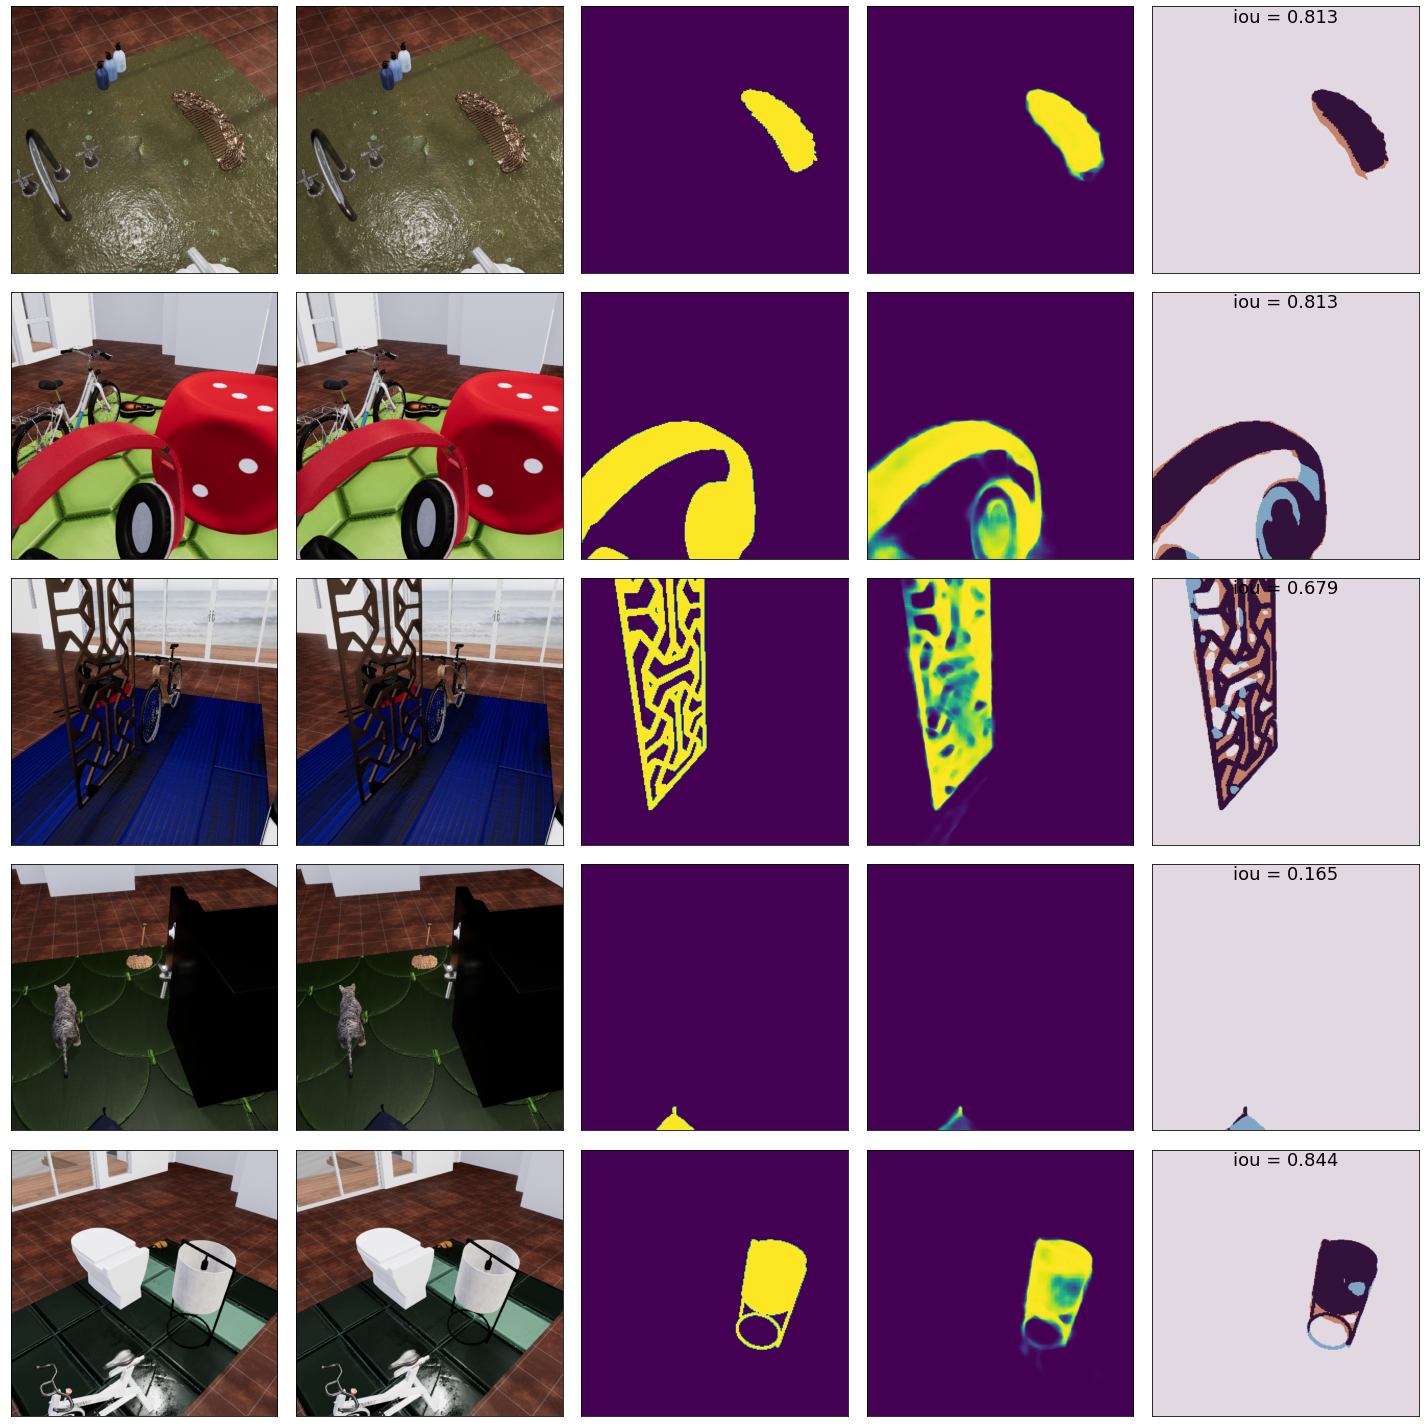

In [44]:
# motion_load_path = '35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth'
# mclass_net = load_model(os.path.join('../checkpoints/', motion_load_path),
#                         train=False, cuda=True, freeze_bn=False, small=True, gpus=[0])

tdw_dataset.is_test = False
tdw_dataset.get_backward_frame = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
bbnet.module.set_mode('train_motion')

examples = range(1,51,10)
visualize_error_maps(bbnet, tdw_dataset, teacher=None,
                     examples=examples, thresh=0.5, thingness=True, iters=6, pred_idx=0,
                     sigmoid=True, upsample=True)



/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


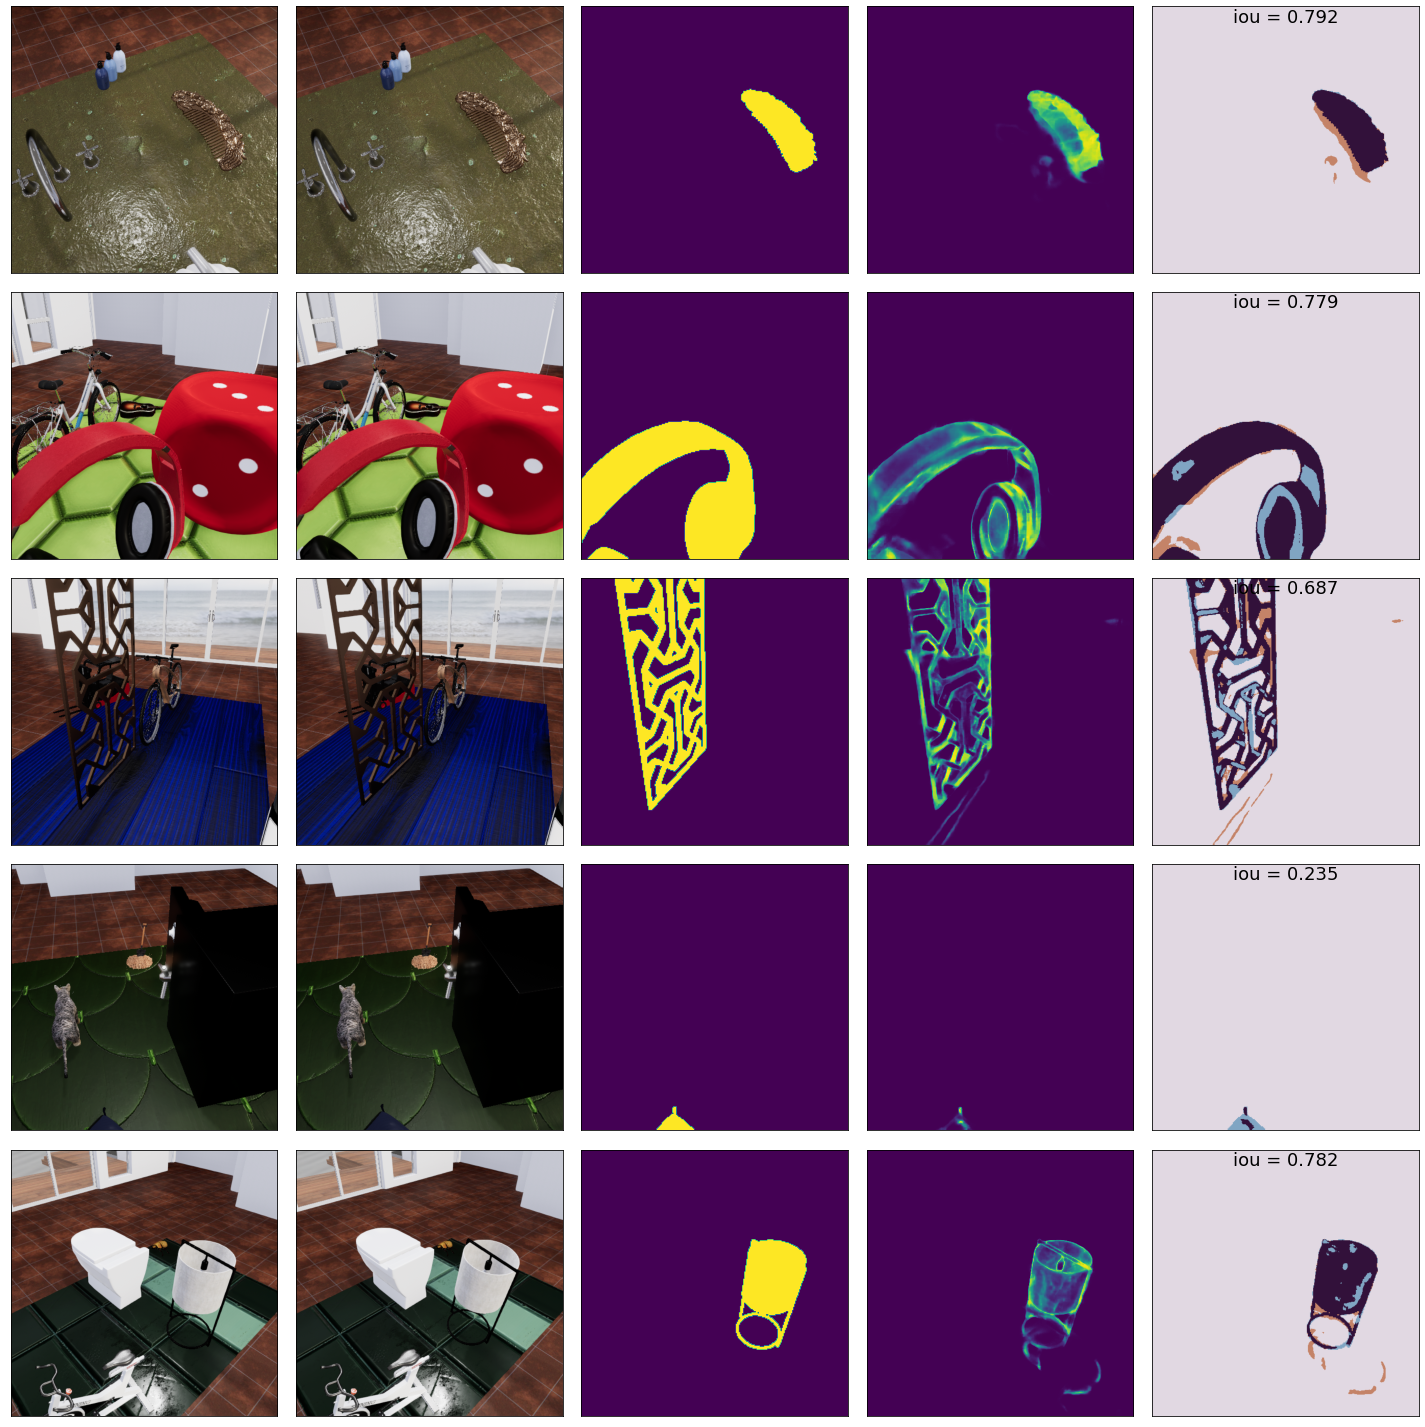

In [45]:
# motion_load_path = '35000_motion-rnd0-tdw-bs8-small-fullplay-tr0-8.pth'
# mclass_net = load_model(os.path.join('../checkpoints/', motion_load_path),
#                         train=False, cuda=True, freeze_bn=False, small=True, gpus=[0])

tdw_dataset.is_test = False
tdw_dataset.get_backward_frame = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(1,51,10)
visualize_error_maps(mclass_net, tdw_dataset, examples=examples, thresh=0.1, thingness=True, iters=24, pred_idx=-1)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


model in train_motion mode


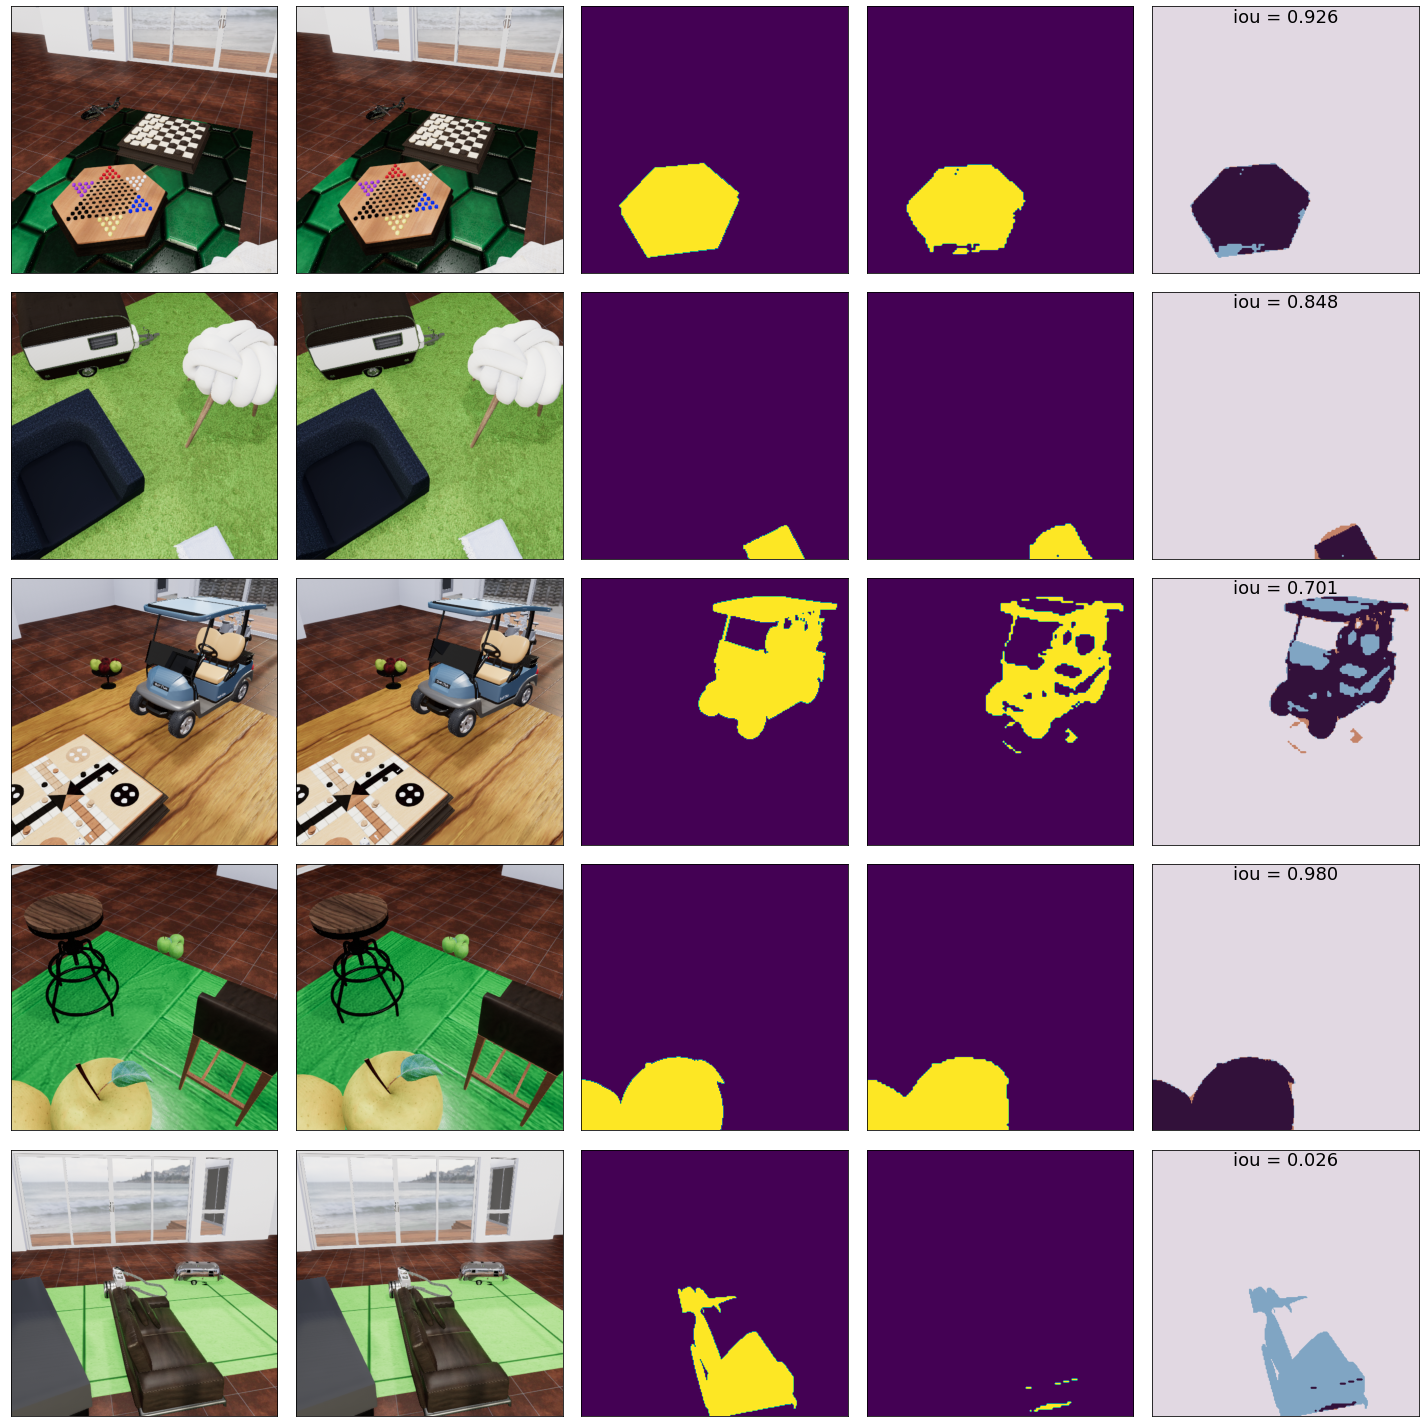

In [17]:
# load_path = '../checkpoints/bbnet_split4full_rnd1static_ep8wd.pth'
# load_path = '../checkpoints/bbnet_split4full_rnd0motion12itSeq_ep25.pth'
# load_path = '../checkpoints/bbnet_split4full_rnd1motion_ep4wd.pth'
# load_path = '../checkpoints/bbnet_split4full_rnd0static_ep20.pth'

bbnet.eval()
bbnet.module.set_mode('train_motion')
thresh = 0.9

tdw_dataset.is_test = False
tdw_dataset.get_backward_frame = False
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5
examples = range(1,51,10)
visualize_error_maps(bbnet, tdw_dataset, teacher=mclass_net,
                     examples=examples, thresh=thresh, thingness=True, iters=12, 
                     pred_idx=-2, sigmoid=False, upsample=False)

In [60]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=None,
                            thingness=True, pred_idx=0, upsample=True, sigmoid=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/5000_bbnet_rnd0motion_fullplayFr5_bs8.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<04:40,  1.78it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [04:31<00:00,  1.84it/s]


({'iou': 0.5943421667638775,
  'precision': 0.8675002705144834,
  'recall': 0.6612476608286051},
 {'iou_isnan': 0.044, 'precision_isnan': 0.05, 'recall_isnan': 0.048})

In [57]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=None,
                            thingness=True, pred_idx=0, upsample=True, sigmoid=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/20000_bbnet_rnd0motion_fullplayFr5_bs8.pth --- val = True, 500 at thresh = 0.50


 21%|██        | 105/500 [01:42<06:10,  1.07it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [08:06<00:00,  1.03it/s]


({'iou': 0.6615004875424327,
  'precision': 0.8407625393876148,
  'recall': 0.7657756984794589},
 {'iou_isnan': 0.046, 'precision_isnan': 0.052, 'recall_isnan': 0.048})

In [54]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=None,
                            thingness=True, pred_idx=0, upsample=True, sigmoid=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/10000_bbnet_rnd0motion_fullplayFr5_bs8.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:01<09:06,  1.10s/it]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [10:57<00:00,  1.32s/it]


({'iou': 0.669439855522973,
  'precision': 0.8738222037666903,
  'recall': 0.7489632385528052},
 {'iou_isnan': 0.048, 'precision_isnan': 0.056, 'recall_isnan': 0.048})

In [55]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.99

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=None,
                            thingness=True, pred_idx=-2, upsample=True, sigmoid=False)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/10000_bbnet_rnd0motion_fullplayFr5_bs8.pth --- val = True, 500 at thresh = 0.99


  0%|          | 1/500 [00:01<08:28,  1.02s/it]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [06:59<00:00,  1.19it/s]


({'iou': 0.6857026438840333,
  'precision': 0.8120383338229311,
  'recall': 0.8234334892590727},
 {'iou_isnan': 0.04, 'precision_isnan': 0.042, 'recall_isnan': 0.048})

In [47]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=None,
                            thingness=True, pred_idx=0, upsample=True, sigmoid=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/40000_bbnet_rnd0motion_fullplayFr5_bs8.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<08:14,  1.01it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [08:20<00:00,  1.00s/it]


({'iou': 0.6562816835035444,
  'precision': 0.8586434186711485,
  'recall': 0.7446143771346865},
 {'iou_isnan': 0.048, 'precision_isnan': 0.066, 'recall_isnan': 0.048})

In [48]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.99

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=None,
                            thingness=True, pred_idx=-2, upsample=True, sigmoid=False)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/40000_bbnet_rnd0motion_fullplayFr5_bs8.pth --- val = True, 500 at thresh = 0.99


  0%|          | 1/500 [00:00<04:47,  1.74it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [04:42<00:00,  1.77it/s]


({'iou': 0.6683278382901913,
  'precision': 0.8101485744163257,
  'recall': 0.8005643103472335},
 {'iou_isnan': 0.042, 'precision_isnan': 0.046, 'recall_isnan': 0.048})

In [54]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=None,
                            thingness=True, pred_idx=0, upsample=True, sigmoid=True)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/10000_motiontest_0.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<05:11,  1.60it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [10:02<00:00,  1.21s/it]


({'iou': 0.6704951678932244,
  'precision': 0.8304531383696868,
  'recall': 0.7801106661010717},
 {'iou_isnan': 0.042, 'precision_isnan': 0.048, 'recall_isnan': 0.048})

In [55]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.99

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=None,
                            thingness=True, pred_idx=-2, upsample=True, sigmoid=False)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/10000_motiontest_0.pth --- val = True, 500 at thresh = 0.99


  0%|          | 1/500 [00:00<04:19,  1.92it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [04:32<00:00,  1.84it/s]


({'iou': 0.6883605130739947,
  'precision': 0.7830439649913399,
  'recall': 0.8599949547013025},
 {'iou_isnan': 0.04, 'precision_isnan': 0.042, 'recall_isnan': 0.048})

In [36]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.99

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=mclass_net,
                            thingness=True, pred_idx=-2, upsample=True, sigmoid=False)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/30000_bbnet_rnd0static_fullplayFr5_bs8.pth --- val = True, 500 at thresh = 0.99


  0%|          | 1/500 [00:00<04:40,  1.78it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [11:17<00:00,  1.36s/it]


({'iou': 0.664092204209283,
  'precision': 0.8275726724426624,
  'recall': 0.7779370668831413},
 {'iou_isnan': 0.028, 'precision_isnan': 0.032, 'recall_isnan': 0.048})

In [38]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=mclass_net,
                            thingness=True, pred_idx=-2, upsample=False, sigmoid=False)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/30000_bbnet_rnd0static_fullplayFr5_bs8.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:00<06:17,  1.32it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [04:49<00:00,  1.73it/s]


({'iou': 0.6344095386857179,
  'precision': 0.8650986262956588,
  'recall': 0.7071358457877406},
 {'iou_isnan': 0.03, 'precision_isnan': 0.034, 'recall_isnan': 0.048})

In [27]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=mclass_net,
                            thingness=True, pred_idx=-2)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/20000_bbnet_rnd0static_fullplayFr5_bs8.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:01<08:42,  1.05s/it]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [10:23<00:00,  1.25s/it]


({'iou': 0.6275979244483778,
  'precision': 0.8585446929375066,
  'recall': 0.703266889478587},
 {'iou_isnan': 0.03, 'precision_isnan': 0.032, 'recall_isnan': 0.048})

In [15]:
tdw_dataset.is_test = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.5

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (load_path, tdw_dataset.is_test, len(tdw_dataset), thresh))
metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=mclass_net,
                            thingness=True, pred_idx=-2)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/20000_bbnet_rnd0static_fullplayFr5_bs4.pth --- val = True, 500 at thresh = 0.50


  0%|          | 1/500 [00:01<08:23,  1.01s/it]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [10:33<00:00,  1.27s/it]


({'iou': 0.6289611186941896,
  'precision': 0.8598591420912696,
  'recall': 0.7032134052428219},
 {'iou_isnan': 0.03, 'precision_isnan': 0.034, 'recall_isnan': 0.048})

In [22]:
tdw_dataset.test_mode = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = None
thresh = 0.1

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=6, 
                            thingness=True, pred_idx=-1)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 1/500 [00:00<01:29,  5.60it/s]

evaluating model --- ../checkpoints/motion-rnd0-tdw-bs8-large-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [06:21<00:00,  1.31it/s]


({'iou': 0.6253278101022259,
  'precision': 0.8190467954913853,
  'recall': 0.7305470564518968},
 {'iou_isnan': 0.032, 'precision_isnan': 0.034, 'recall_isnan': 0.048})

In [35]:
tdw_dataset.test_mode = True
tdw_dataset.min_start_frame = 5
tdw_dataset.max_start_frame = 5

examples = range(10)
thresh = 0.1

print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
      (motion_path, tdw_dataset.test_mode, len(tdw_dataset), thresh))
metrics = validate_examples(mclass_net, tdw_dataset, examples=examples, thresh=thresh, iters=6, 
                            thingness=True, pred_idx=-1)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/10 [00:00<?, ?it/s]

evaluating model --- ../checkpoints/motion-rnd0-tdw-bs8-large-fullplay-tr0-8.pth --- val = True, 500 at thresh = 0.10


 10%|█         | 1/10 [00:00<00:02,  3.88it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


({'iou': 0.7211675927647714,
  'precision': 0.826233121735438,
  'recall': 0.8546961809830522},
 {'iou_isnan': 0.1, 'precision_isnan': 0.1, 'recall_isnan': 0.1})

### create ex post facto validation curves

In [87]:
_stem = lambda s: '_'.join(s.split('_')[1:])
ckpts = !ls ../checkpoints/*bbnet_rnd0*
models = list(sorted(set([_stem(s) for s in ckpts])))
for i,m in enumerate(models):
    print(i, m)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 bbnet_rnd0static_fullplayFr5_bs4.pth
1 bbnet_rnd0static_fullplayFr5_bs8.pth


In [88]:
model_i = 1
model_ckpts = sorted([int(c.split('/')[-1].split('_')[0]) for c in ckpts if models[model_i] in c])
lps = [osp.join('../checkpoints', str(step) + '_' + models[model_i]) for step in model_ckpts]
lps

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['../checkpoints/5000_bbnet_rnd0static_fullplayFr5_bs8.pth',
 '../checkpoints/10000_bbnet_rnd0static_fullplayFr5_bs8.pth',
 '../checkpoints/15000_bbnet_rnd0static_fullplayFr5_bs8.pth',
 '../checkpoints/20000_bbnet_rnd0static_fullplayFr5_bs8.pth',
 '../checkpoints/25000_bbnet_rnd0static_fullplayFr5_bs8.pth',
 '../checkpoints/30000_bbnet_rnd0static_fullplayFr5_bs8.pth',
 '../checkpoints/35000_bbnet_rnd0static_fullplayFr5_bs8.pth',
 '../checkpoints/40000_bbnet_rnd0static_fullplayFr5_bs8.pth']

In [89]:
from collections import OrderedDict
# results = OrderedDict()
for i,lp in enumerate(lps[-1:]):
    if lp in list(results.keys()):
        print("already evaluated %s" % lp)
        continue
    bbnet = load_model(static_load_path=lp, model_class='bbnet',
                       train=False, cuda=True, affinity_radius=5)
    bbnet.module.set_mode('train_motion')
    tdw_dataset.is_test = True
    tdw_dataset.min_start_frame = 5
    tdw_dataset.max_start_frame = 5

    examples = None
    thresh = 0.9

    print("evaluating model --- %s --- val = %s, %d at thresh = %0.2f" % 
          (lp, tdw_dataset.is_test, len(tdw_dataset), thresh))
    metrics = validate_examples(bbnet, tdw_dataset, examples=examples, thresh=thresh, iters=6, teacher=mclass_net,
                                thingness=True, pred_idx=-2, upsample=True, sigmoid=False)
    results[lp] = agg_metrics(metrics)
    print(lp, results[lp])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

model in train_static mode
loaded static weights only, not _IncompatibleKeys(missing_keys=['module.motion_model.encoder.embed.encoders.0.gate.conv.weight', 'module.motion_model.encoder.embed.encoders.0.gate.norm.weight', 'module.motion_model.encoder.embed.encoders.0.gate.norm.bias', 'module.motion_model.encoder.embed.encoders.0.gate.f.0.weight', 'module.motion_model.encoder.embed.encoders.0.gate.f.1.weight', 'module.motion_model.encoder.embed.encoders.0.gate.f.1.bias', 'module.motion_model.encoder.embed.encoders.0.blocks.0.blocks.0.conv1.conv.weight', 'module.motion_model.encoder.embed.encoders.0.blocks.0.blocks.0.conv1.norm.weight', 'module.motion_model.encoder.embed.encoders.0.blocks.0.blocks.0.conv1.norm.bias', 'module.motion_model.encoder.embed.encoders.0.blocks.0.blocks.0.conv1.f.0.weight', 'module.motion_model.encoder.embed.encoders.0.blocks.0.blocks.0.conv1.f.1.weight', 'module.motion_model.encoder.embed.encoders.0.blocks.0.blocks.0.conv1.f.1.bias', 'module.motion_model.encoder.

  0%|          | 1/500 [00:00<05:10,  1.61it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [04:57<00:00,  1.68it/s]

../checkpoints/40000_bbnet_rnd0static_fullplayFr5_bs8.pth ({'iou': 0.6641909882857518, 'precision': 0.8266286949757653, 'recall': 0.779309270759094}, {'iou_isnan': 0.032, 'precision_isnan': 0.036, 'recall_isnan': 0.048})


In [78]:
results

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OrderedDict([('../checkpoints/5000_bbnet_rnd0static_fullplayFr5_bs8.pth',
              ({'iou': 0.6692511173414981,
                'precision': 0.8170690994032754,
                'recall': 0.7939232887746935},
               {'iou_isnan': 0.032,
                'precision_isnan': 0.034,
                'recall_isnan': 0.048})),
             ('../checkpoints/10000_bbnet_rnd0static_fullplayFr5_bs8.pth',
              ({'iou': 0.6608244029962896,
                'precision': 0.8158800663299534,
                'recall': 0.7828751890297954},
               {'iou_isnan': 0.032,
                'precision_isnan': 0.034,
                'recall_isnan': 0.048})),
             ('../checkpoints/15000_bbnet_rnd0static_fullplayFr5_bs8.pth',
              ({'iou': 0.6598080648525902,
                'precision': 0.8209667307288148,
                'recall': 0.7789925211283684},
               {'iou_isnan': 0.03,
                'precision_isnan': 0.034,
                'recall_isnan': 0.048})),


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


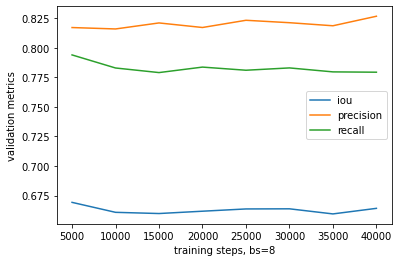

In [92]:
keys = list(results.keys())
plt.plot([results[k][0]['iou'] for k in keys], label='iou')
plt.plot([results[k][0]['precision'] for k in keys], label='precision')
plt.plot([results[k][0]['recall'] for k in keys], label='recall')
plt.xticks(range(len(keys)), [str(5000*(i+1)) for i in range(len(keys))])
plt.xlabel('training steps, bs=8')
plt.ylabel('validation metrics')
plt.legend()
plt.show()